In [1]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import statsmodels.tsa.stattools as st
import time
from sklearn.decomposition import PCA
from statsmodels.tsa.api import VAR
from statsmodels.tsa.vector_ar import var_model
plt.rcParams['figure.figsize'] = [20, 12]
plt.rcParams.update({'font.size': 15})

# Abstract

Stock and Watson (2002) argue that factor models are either able to cope with breaks in the factor loadings in a fraction of the series, or can account for moderate parameter drift in all of the series. However, in empirical applications parameters may change dramatically due to important economic events. There may also be more gradual but fundamental changes in economic structures that may have led to significant changes in the comovements of variables. We hypothesize that the 2008 stock market crash is a dramatic important economic event, and perform a hypothesis test to see if it is the location of a structural break. We then investigate the principal factors before and after the crash.

Thus, time-varying factor loadings lead not only to inconsistent estimates of the loadings but also to a larger dimension of the factor space. Since high-dimensional factor spaces suffer from something known as the "curse of dimensionality", low dimensions are desirable which necessitates consideration of time-varying factor loadings.

# Introduction

## Data: Macroeconomic Database FRED-MD

Description of dataset: FRED is the Federal Reserve's Economic Data, which tracks hundreds of thousands of time series. FRED-MD and FRED-QD are subsets of the data that describe monthly and quarterly time series. They are updated in real time as the FRED dataset is updated. In our [FRED-MD](https://research.stlouisfed.org/econ/mccracken/fred-databases/) set, there are 127 features, and there is 1 observation for each month, from the beginning of 1959 to September 2020.

In [2]:
# macroeconomic database of monthly U.S. indicators 
# such as output and income, the labor market and prices from 1959 to 2020
df = pd.read_csv(r"current.csv")
df

,sasdate,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,...,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,UMCSENTx,MZMSL,DTCOLNVHFNM,DTCTHFNM,INVEST,VXOCLSx
0,Transform:,5.000,5.0,5.000,5.000000e+00,5.00000,5.0000,5.0000,5.0000,5.0000,...,6.000,6.00,6.00,6.00,2.0,6.0,6.00,6.00,6.0000,1.0000
1,1/1/1959,2437.296,2288.8,17.302,2.922588e+05,18235.77392,22.6250,23.4581,22.1904,32.4078,...,11.358,2.13,2.45,2.04,NaN,274.9,6476.00,12298.00,84.2043,NaN
2,2/1/1959,2446.902,2297.0,17.482,2.944295e+05,18369.56308,23.0681,23.7747,22.3827,32.6455,...,11.375,2.14,2.46,2.05,NaN,276.0,6476.00,12298.00,83.5280,NaN
3,3/1/1959,2462.689,2314.0,17.647,2.934254e+05,18523.05762,23.4004,23.9186,22.4925,32.6455,...,11.395,2.15,2.45,2.07,NaN,277.4,6508.00,12349.00,81.6405,NaN
4,4/1/1959,2478.744,2330.3,17.584,2.993317e+05,18534.46600,23.8989,24.2641,22.8221,33.1606,...,11.436,2.16,2.47,2.08,NaN,278.1,6620.00,12484.00,81.8099,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
738,6/1/2020,17990.747,13521.2,114.880,1.515750e+06,529962.00000,97.6071,93.9394,93.0396,98.6589,...,119.838,25.38,29.32,22.61,78.1,20979.3,334036.91,719924.00,4170.7929,30.0744
739,7/1/2020,18110.849,13713.8,116.322,1.549057e+06,535923.00000,101.6989,98.0911,97.7693,103.5054,...,120.048,25.44,29.30,22.81,72.5,21079.5,338930.02,725019.07,4290.0949,24.3785
740,8/1/2020,17609.010,13875.6,117.152,1.550404e+06,538979.00000,102.1509,99.0661,98.6480,104.2163,...,120.360,25.47,29.40,22.81,74.1,21114.7,341624.48,727855.23,4344.8069,20.2777
741,9/1/2020,17733.106,14010.5,118.599,NaN,549256.00000,101.5055,97.9490,97.3806,102.5015,...,120.741,25.42,29.07,22.94,80.4,21284.1,NaN,NaN,4396.7473,28.3241


In [3]:
select_2000 = df['sasdate'].loc[lambda x: x == "1/1/2000"].index.values[0] # we only want data after 2000
df_2000 = df[select_2000:]
df_2000

,sasdate,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,...,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,UMCSENTx,MZMSL,DTCOLNVHFNM,DTCTHFNM,INVEST,VXOCLSx
493,1/1/2000,10855.813,9496.2,76.772,1129614.0,268044.0,94.1758,99.7323,96.1115,105.0059,...,72.064,15.01,17.11,14.13,112.0,4380.1,132467.09,421056.34,1146.8857,24.8430
494,2/1/2000,10899.897,9538.8,77.513,1109286.0,272020.0,94.4557,100.1398,96.6157,105.6910,...,72.288,15.06,17.20,14.14,111.3,4384.6,136610.16,422437.48,1140.4519,25.4560
495,3/1/2000,10929.236,9568.9,77.955,1122401.0,275192.0,94.7980,100.3403,96.7117,105.2974,...,72.412,15.10,17.28,14.17,107.1,4423.6,136745.97,423323.75,1153.0132,24.7678
496,4/1/2000,10984.370,9611.6,77.859,1131729.0,271046.0,95.4808,101.2764,97.6049,106.2820,...,72.428,15.17,17.39,14.23,109.2,4475.4,136863.39,427912.64,1160.0962,29.8331
497,5/1/2000,11021.996,9617.4,78.229,1125723.0,271394.0,95.6435,101.2848,97.7916,106.3292,...,72.553,15.17,17.38,14.22,110.7,4465.5,140410.20,432485.03,1164.4933,29.4290
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
738,6/1/2020,17990.747,13521.2,114.880,1515750.0,529962.0,97.6071,93.9394,93.0396,98.6589,...,119.838,25.38,29.32,22.61,78.1,20979.3,334036.91,719924.00,4170.7929,30.0744
739,7/1/2020,18110.849,13713.8,116.322,1549057.0,535923.0,101.6989,98.0911,97.7693,103.5054,...,120.048,25.44,29.30,22.81,72.5,21079.5,338930.02,725019.07,4290.0949,24.3785
740,8/1/2020,17609.010,13875.6,117.152,1550404.0,538979.0,102.1509,99.0661,98.6480,104.2163,...,120.360,25.47,29.40,22.81,74.1,21114.7,341624.48,727855.23,4344.8069,20.2777
741,9/1/2020,17733.106,14010.5,118.599,NaN,549256.0,101.5055,97.9490,97.3806,102.5015,...,120.741,25.42,29.07,22.94,80.4,21284.1,NaN,NaN,4396.7473,28.3241


According to the FRED-MD paper, these 7 factors have the greatest explanatory power, so we will use them from now on. The abbreviations stand for the rough "value" of the following:
- USGOOD: All employees: Goods-Producing Industries
- PAYEMS: All employees: Total nonfarm
- MANEMP: All employees: Manufacturing
- DMANEMP: All employees: Durable goods
- INDPRO: IP (Intellectual Property) product
- IPMANSICS: IP: Manufacturing
- CUMFNS: Capacity Utilization: Manufacturing

In [4]:
fred7 = df_2000[['USGOOD', 'PAYEMS', 'MANEMP', 'IPMANSICS', 'DMANEMP', 'INDPRO', 'CUMFNS']].copy()
# drop any column that has a nan value, as well as the first "transformation" row
fred7 = fred7.dropna()[1:]
fred7

,USGOOD,PAYEMS,MANEMP,IPMANSICS,DMANEMP,INDPRO,CUMFNS
494,24609.0,131124.0,17285.0,97.3902,10850.0,94.4557,80.5127
495,24705.0,131596.0,17302.0,97.9894,10870.0,94.7980,80.6778
496,24688.0,131888.0,17298.0,98.7085,10867.0,95.4808,80.9409
497,24647.0,132105.0,17279.0,98.5747,10871.0,95.6435,80.5064
498,24672.0,132061.0,17296.0,98.7757,10907.0,95.7353,80.3493
...,...,...,...,...,...,...,...
737,19374.0,133028.0,11729.0,86.8627,7269.0,91.9327,62.2391
738,19859.0,137809.0,12062.0,93.5020,7534.0,97.6071,67.0188
739,19925.0,139570.0,12103.0,97.4069,7561.0,101.6989,69.8435
740,19970.0,141059.0,12139.0,98.5465,7568.0,102.1509,70.6884


We will not look at data before Jan 1st, 2000 or after Jan 1st, 2020. This is because there was a significant market crash in 1987, and we want to isolate 1 specific structural break at a time. Other crashes/recessions would be confounding factors. 

It also turns out coronavirus is causing a huge number of outliers in our data, so we will drop the months after March 2020.


In [5]:
fred7 = fred7[:-8]
# grab the dates for plotting purposes
dates = df['sasdate'][1:-9]

In [6]:
# transform it into an numpy ndarray
fred7_array = fred7.to_numpy().T
fred7_array

array([[2.460900e+04, 2.470500e+04, 2.468800e+04, ..., 2.113100e+04,
        2.113600e+04, 2.114900e+04],
       [1.311240e+05, 1.315960e+05, 1.318880e+05, ..., 1.518140e+05,
        1.519980e+05, 1.522120e+05],
       [1.728500e+04, 1.730200e+04, 1.729800e+04, ..., 1.286800e+04,
        1.286600e+04, 1.284400e+04],
       ...,
       [1.085000e+04, 1.087000e+04, 1.086700e+04, ..., 8.064000e+03,
        8.064000e+03, 8.052000e+03],
       [9.445570e+01, 9.479800e+01, 9.548080e+01, ..., 1.100388e+02,
        1.096527e+02, 1.091845e+02],
       [8.051270e+01, 8.067780e+01, 8.094090e+01, ..., 7.519710e+01,
        7.525350e+01, 7.519360e+01]])

### Adjust for the non-stationarity in the dataset

In [7]:
# difference the non-stationary series to stationarity
# check for non-stationary and take differences of non-stationary series
def non_stationary(timeseries):
    # Perform augmented Dickey-Fuller test and return whether the test statistic is greater than the critical value,
    # which means the time series is non-stationary. We pick an alpha = 0.10
    dftest = st.adfuller(timeseries, autolag='AIC')
    test_statistic = dftest[0]
    crit_value = dftest[4]['10%']
    return test_statistic > crit_value

stationary_fred7 = fred7_array.copy()
# print(len(stationary_fred7))
# print(len(stationary_fred7[0]))
for i in range(len(stationary_fred7)):
    if non_stationary(stationary_fred7[i]):
        diffs = []
        for j in range(1, len(stationary_fred7[i])):
            diffs.append(stationary_fred7[i][j] - stationary_fred7[i][j-1])
        diffs.insert(0, np.mean(diffs))
        stationary_fred7[i] = diffs

# print(stationary_fred7.shape)

### Standardize the dataset

In [8]:
def center(series):
    zero_mean = series - np.mean(series)
    unit_variance = zero_mean / (np.std(series))
    return unit_variance

In [9]:
# standardize all columns to have zero mean and unit variance
whitened_fred7 = np.empty(shape=(0,0))
for col in stationary_fred7:
    # don't apply this to malformed columns, i.e. columns with nan or non-floats
    if not isinstance(col[0], str):
        whitened_fred7 = np.append(whitened_fred7, center(col))
whitened_fred7 = whitened_fred7.reshape(stationary_fred7.shape)

In [10]:
# reindexing whiten_fred7
index_fred = df_2000.loc[fred7.index[0]:fred7.index[-1]]
date_index_fred = pd.to_datetime(index_fred['sasdate'])
whitened_fred7_pd = pd.DataFrame(whitened_fred7).T.set_index(date_index_fred)
whitened_fred7_pd
# pd.DataFrame(whitened_fred7)

,0,1,2,3,4,5,6
sasdate,,,,,,,
2000-02-01,2.012381,-6.617601e-17,2.523953,-0.606197,2.478533,0.000000,1.733946
2000-03-01,2.062253,1.787090e+00,2.534852,-0.481445,2.498399,0.434311,1.785024
2000-04-01,2.053422,9.488803e-01,2.532288,-0.331731,2.495419,0.961198,1.866422
2000-05-01,2.032122,5.996261e-01,2.520106,-0.359588,2.499392,0.156400,1.731997
2000-06-01,2.045110,-6.157785e-01,2.531005,-0.317740,2.535149,0.046690,1.683394
...,...,...,...,...,...,...,...
2019-09-01,0.192553,5.577156e-01,-0.318860,0.878579,-0.286696,-0.686154,0.062284
2019-10-01,0.182162,4.506110e-01,-0.345147,0.757096,-0.333379,-0.784723,-0.094787
2019-11-01,0.205540,8.045219e-01,-0.307961,0.955487,-0.288682,1.470289,0.089417


Text(0.5, 1.0, '7 Macroeconomic Indicators')

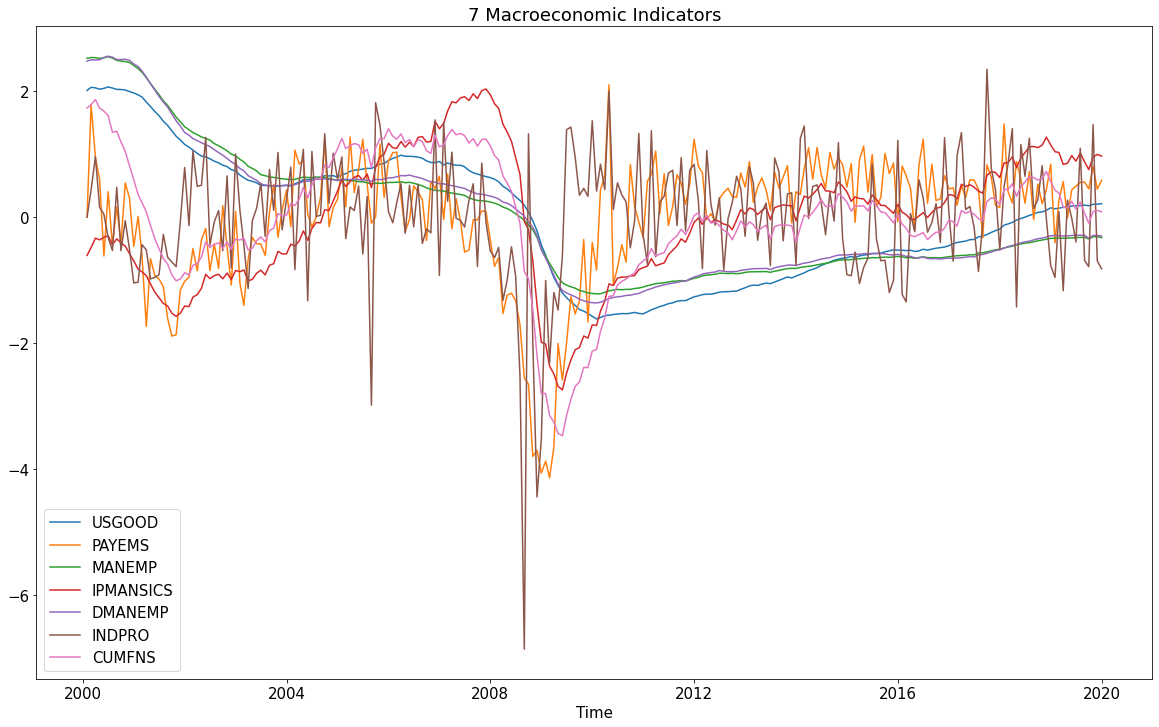

In [41]:
# plt.plot([np.log(i) for i in fred7[1]])
# plt.plot([np.log(i) for i in fred7[2]])
# plt.plot([np.log(i) for i in fred7[3]])
plt.plot(whitened_fred7_pd[[0]])
plt.plot(whitened_fred7_pd[[1]])
plt.plot(whitened_fred7_pd[[2]])
plt.plot(whitened_fred7_pd[[3]])
plt.plot(whitened_fred7_pd[[4]])
plt.plot(whitened_fred7_pd[[5]])
plt.plot(whitened_fred7_pd[[6]])
plt.legend(['USGOOD', 'PAYEMS', 'MANEMP', 'IPMANSICS', 'DMANEMP', 'INDPRO', 'CUMFNS'])
plt.xlabel('Time')
plt.title('7 Macroeconomic Indicators')

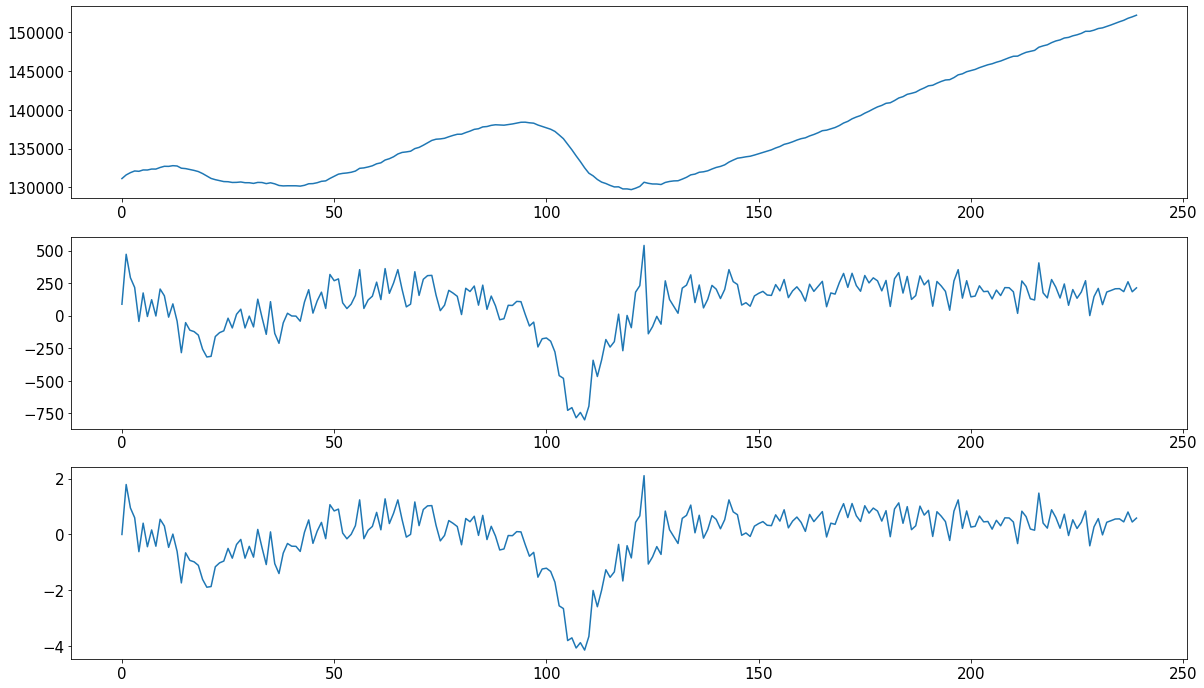

In [12]:
# Check stationarity
def plotter(index):
    fig, axs = plt.subplots(3)
    fig.figsize = [6.4, 9.6]
    axs[0].plot(fred7_array[index])
    axs[1].plot(stationary_fred7[index])
    axs[2].plot(whitened_fred7[index])
plotter(1)

In [13]:
feat_cols = ['feature'+str(i) for i in range(whitened_fred7.shape[0])]
normalized_fred7 = pd.DataFrame(whitened_fred7.T,columns=feat_cols)
normalized_fred7

,feature0,feature1,feature2,feature3,feature4,feature5,feature6
0,2.012381,-6.617601e-17,2.523953,-0.606197,2.478533,0.000000,1.733946
1,2.062253,1.787090e+00,2.534852,-0.481445,2.498399,0.434311,1.785024
2,2.053422,9.488803e-01,2.532288,-0.331731,2.495419,0.961198,1.866422
3,2.032122,5.996261e-01,2.520106,-0.359588,2.499392,0.156400,1.731997
4,2.045110,-6.157785e-01,2.531005,-0.317740,2.535149,0.046690,1.683394
...,...,...,...,...,...,...,...
235,0.192553,5.577156e-01,-0.318860,0.878579,-0.286696,-0.686154,0.062284
236,0.182162,4.506110e-01,-0.345147,0.757096,-0.333379,-0.784723,-0.094787
237,0.205540,8.045219e-01,-0.307961,0.955487,-0.288682,1.470289,0.089417
238,0.208138,4.459543e-01,-0.309243,0.997376,-0.288682,-0.692808,0.106866


This is the normalized aggregate data we will use to test for time-varying loadings.

## Testing for time-varying loadings

Test the null hypothesis that the time loadings are time-invariant by testing the autocorrelation in the residuals.

In [14]:
# Determine lag order from the average of all features
N = len(normalized_fred7.columns)
T = len(normalized_fred7.index)
optimal_lag = np.array([])
for j in range(0, N):
    k = 0
    highestCorr = 0
    for i in range(1, 10):
        cor = pd.Series.autocorr(normalized_fred7.iloc[:, j].astype(float), lag = i)
        if(cor > highestCorr):
            highestCorr = cor
            k = i
    optimal_lag = np.append(optimal_lag, k)
optimal_lag

array([1., 1., 1., 1., 1., 3., 1.])

In [15]:
p = int(np.round(np.mean(optimal_lag)))
p

1

Find the rejection rate of the null hypothesis that the autocorrelations of the residual time series are not different from zero (also called the Ljung–Box test), thus testing for serial correlation between the features.

Plot all the features.

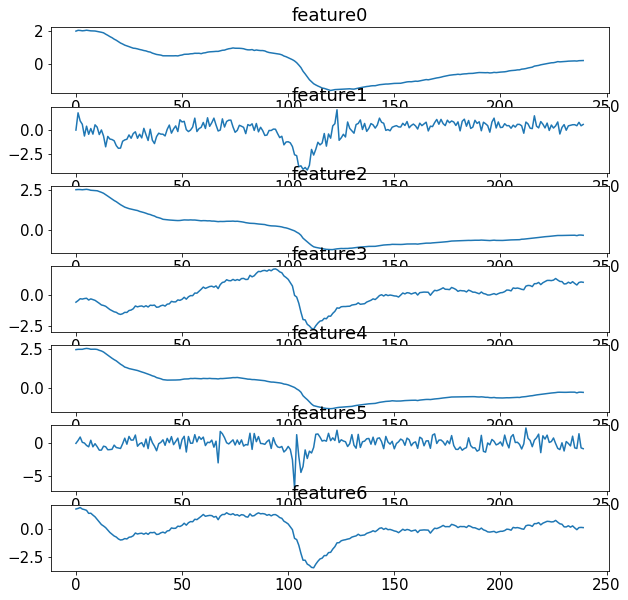

In [16]:
test_fred_7 = normalized_fred7
model = VAR(test_fred_7.astype(float))
results_7= model.fit(p, method = "ols")
results_7.plot();

In [17]:
resid_test_7 = var_model.VARResults.test_whiteness(results_7, nlags=10, signif=0.05, adjusted=False)
resid_test_7.summary()

Test statistic,Critical value,p-value,df
1628.,491.0,0.000,441


In [18]:
resid_test_7.pvalue <= 0.05

True

Since $p \leq 0.05$, we reject the null hypothesis that the residual autocorrelations are 0. In other words, since the autocorrelations are significantly different from 0, the data is serially correlated, which shows seasonality.

We also test different lag orders to see how the p-value of the null hypothesis test changes with lag order.

In [19]:
# test for appropriate range
results_test = results_7
resid_test = var_model.VARResults.test_whiteness(results_test, nlags=150, signif=0.05, adjusted=False)
resid_test.pvalue

6.763929340065576e-09

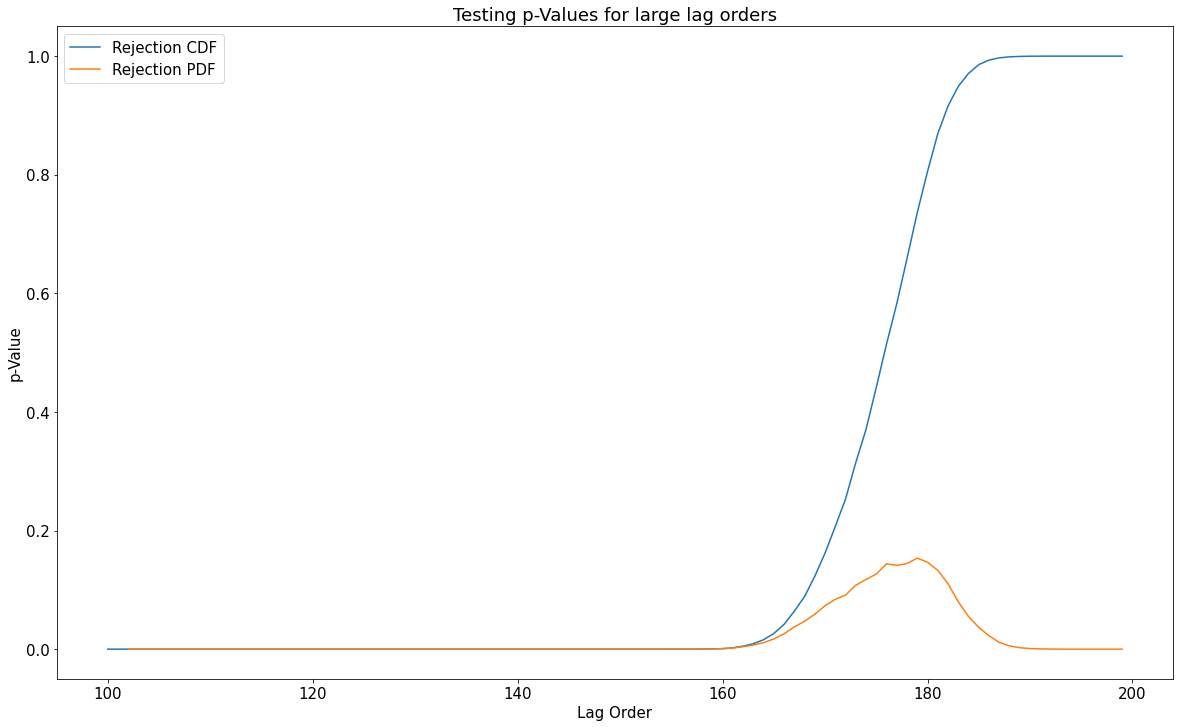

In [43]:
rejection_CDF = pd.Series([var_model.VARResults.test_whiteness(results_test, nlags=i, signif=0.05, adjusted=False).pvalue for i in range(100, 200)])
rejection_PDF = rejection_CDF - rejection_CDF.shift(2)
# var_model.VARResults.test_whiteness?
plt.plot(range(100, 200), rejection_CDF)
plt.plot(range(100, 200), rejection_PDF)
plt.legend(['Rejection CDF','Rejection PDF'], loc = 'upper left')
plt.title('Testing p-Values for large lag orders')
plt.xlabel('Lag Order')
plt.ylabel('p-Value');

# Application (Body)

## PCA with structural breaks

This dataset is compiled by Kenneth R. French, a renowned finance professor and co-author of the famous "5 Factor Model" paper. The actual dataset itself is a Cartesian product of 10 x 10 portfolios: 10 portfolios representing the market equity deciles as from NYSE, compiled at June of each year, and 10 portfolios representing the deciles of the ratio of book equity to market equity (also compiled at June of each year). Thus this set of 100 portfolios gives a representative view of the market in any year, subdivided into months.

In [21]:
# 100 portfolios excess returns on 100 portfolios sorted on size and book-to-market
df2 = pd.read_csv(r"100_Portfolios_10x10.csv")
df2.rename(columns = {"Unnamed: 0": "Time"}, inplace=True)
df2

C:\Users\shena\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,Time,SMALL LoBM,ME1 BM2,ME1 BM3,ME1 BM4,ME1 BM5,ME1 BM6,ME1 BM7,ME1 BM8,ME1 BM9,...,BIG LoBM,ME10 BM2,ME10 BM3,ME10 BM4,ME10 BM5,ME10 BM6,ME10 BM7,ME10 BM8,ME10 BM9,BIG HiBM
0,192607,-99.99,12.3656,-99.99,-20.6349,-6.4864,-4.7429,-4.8812,15.7276,-1.6398,...,3.3411,1.182,19.0161,1.4227,1.9459,2.4834,3.1644,0.3378,0.8576,-99.99
1,192608,-99.99,2.9904,-99.99,8,6.7495,-3.5639,-4.1188,-1.6529,-5.3824,...,0.2379,3.9628,8.5675,3.0099,1.1427,3.0263,6.0936,6.0606,11.2245,-99.99
2,192609,-99.99,-18.583,-99.99,-3.7037,-5.0512,-2.1739,-4.5714,-10.61,0.4919,...,-0.392,-1.9836,10.7849,0.8073,-0.9185,1.0889,-0.5436,-0.9524,-1.0703,-99.99
3,192610,-99.99,-4.1369,-99.99,-11.5385,-5.3996,-17.7778,3.5554,-9.2233,-9.1593,...,-4.32,-0.648,-6.6205,-0.5337,-1.5745,-1.9202,-5.3535,-0.9615,-3.9246,-99.99
4,192611,-99.99,-8.2589,-99.99,34.7826,1.2296,0.2027,-4.8789,-3.201,-1.8459,...,6.9978,-0.0541,0.4585,2.9192,1.1447,0.8811,3.6576,3.7217,3.268,-99.99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8393,202007,0.1071,0.0467,0.2336,0.2217,0.0754,0.1764,0.0633,0.0592,0.0488,...,0.1155,0.0488,0.1478,0.2332,0.2356,0.1679,0.1511,0.0778,0.0392,0.0235
8394,202008,0.0955,0.007,0.2215,0.2197,0.0526,0.1665,0.0589,0.0365,0.0446,...,0.1171,0.0505,0.1491,0.2338,0.2299,0.1734,0.1656,0.0802,0.0395,0.0225
8395,202009,0.1291,0.0475,0.2427,0.2223,0.0864,0.1716,0.063,0.0306,0.0454,...,0.1155,0.0519,0.1532,0.2393,0.2254,0.1692,0.1689,0.0822,0.0397,0.0225
8396,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
# Convert first column to datatime format
df2_date = df2.copy()
df2_date = df2_date.dropna()

for date in df2_date['Time']:
    date = str(date)+"01"
modified_dates = [str(date) + "01" for date in df2_date['Time']]
df2_date['Time'] = modified_dates

df2_date['Time_length'] = df2_date['Time'].map(len)
df2_date = df2_date[df2_date['Time_length'] == 8]

In [23]:
df2_date['Time'] = pd.to_datetime(df2_date['Time'])
df2_date

,Time,SMALL LoBM,ME1 BM2,ME1 BM3,ME1 BM4,ME1 BM5,ME1 BM6,ME1 BM7,ME1 BM8,ME1 BM9,...,ME10 BM2,ME10 BM3,ME10 BM4,ME10 BM5,ME10 BM6,ME10 BM7,ME10 BM8,ME10 BM9,BIG HiBM,Time_length
0,1926-07-01,-99.99,12.3656,-99.99,-20.6349,-6.4864,-4.7429,-4.8812,15.7276,-1.6398,...,1.182,19.0161,1.4227,1.9459,2.4834,3.1644,0.3378,0.8576,-99.99,8
1,1926-08-01,-99.99,2.9904,-99.99,8,6.7495,-3.5639,-4.1188,-1.6529,-5.3824,...,3.9628,8.5675,3.0099,1.1427,3.0263,6.0936,6.0606,11.2245,-99.99,8
2,1926-09-01,-99.99,-18.583,-99.99,-3.7037,-5.0512,-2.1739,-4.5714,-10.61,0.4919,...,-1.9836,10.7849,0.8073,-0.9185,1.0889,-0.5436,-0.9524,-1.0703,-99.99,8
3,1926-10-01,-99.99,-4.1369,-99.99,-11.5385,-5.3996,-17.7778,3.5554,-9.2233,-9.1593,...,-0.648,-6.6205,-0.5337,-1.5745,-1.9202,-5.3535,-0.9615,-3.9246,-99.99,8
4,1926-11-01,-99.99,-8.2589,-99.99,34.7826,1.2296,0.2027,-4.8789,-3.201,-1.8459,...,-0.0541,0.4585,2.9192,1.1447,0.8811,3.6576,3.7217,3.268,-99.99,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8391,2020-05-01,0.1978,0.1872,0.1159,0.2837,0.1398,0.3236,0.1116,0.069,0.1022,...,0.0062,0.0681,0.0736,0.0399,0.2118,0.0441,0.1296,0.0163,0.0223,8
8392,2020-06-01,0.1457,0.1924,0.1168,0.2992,0.0904,0.3665,0.1075,0.0726,0.09,...,0.0054,0.0694,0.0722,0.0418,0.2056,0.0469,0.1302,0.0159,0.0215,8
8393,2020-07-01,0.1071,0.0467,0.2336,0.2217,0.0754,0.1764,0.0633,0.0592,0.0488,...,0.0488,0.1478,0.2332,0.2356,0.1679,0.1511,0.0778,0.0392,0.0235,8
8394,2020-08-01,0.0955,0.007,0.2215,0.2197,0.0526,0.1665,0.0589,0.0365,0.0446,...,0.0505,0.1491,0.2338,0.2299,0.1734,0.1656,0.0802,0.0395,0.0225,8


In [24]:
df2_trim = df2_date.loc[(df2_date['Time'] >= '2000-1-1') & (df2_date['Time'] <= '2015-12-01')]
df2_index = df2_trim.set_index('Time')
df2_index = df2_index.drop(df2_index.columns[-1], axis=1)
df2_index

,SMALL LoBM,ME1 BM2,ME1 BM3,ME1 BM4,ME1 BM5,ME1 BM6,ME1 BM7,ME1 BM8,ME1 BM9,SMALL HiBM,...,BIG LoBM,ME10 BM2,ME10 BM3,ME10 BM4,ME10 BM5,ME10 BM6,ME10 BM7,ME10 BM8,ME10 BM9,BIG HiBM
Time,,,,,,,,,,,,,,,,,,,,,
2000-01-01,19.126,17.0957,26.1272,13.5761,4.4187,5.3212,1.9173,8.6891,10.6126,8.0692,...,-6.422,-1.6136,-4.1085,-2.4143,-4.6638,-5.4389,-8.9173,7.0122,-4.2329,-99.99
2000-02-01,45.7499,30.5864,51.5229,30.8512,23.8502,18.0273,43.6311,21.8096,23.1392,12.7453,...,-1.0276,-2.5381,-8.8494,-3.6078,-2.9501,-13.1782,-13.6474,-5.9829,-22.77,-99.99
2000-03-01,-12.6886,-8.6353,-20.1128,-12.5612,-5.9112,-7.1299,-13.7479,-9.0742,-6.4172,-2.1561,...,10.6119,8.6092,14.6014,8.2968,7.3956,18.0329,19.0972,3.2727,34.9544,-99.99
2000-04-01,-32.581,-26.6134,-27.6293,-19.9624,-14.9647,-6.8884,-19.9219,-14.521,-11.9854,-11.6226,...,-4.3111,-1.0207,-2.9572,-2.8738,-3.9165,3.3144,1.026,23.5119,4.6396,-99.99
2000-05-01,-18.2413,-13.1883,-13.2625,-11.9879,-14.0584,-6.5115,-8.4106,-10.0356,-8.292,-6.7809,...,-3.177,-3.7655,0.0706,-2.3372,4.2307,8.3156,0.7531,0,15.3348,-99.99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-08-01,0.2171,0.2081,0.3272,0.1702,0.2432,0.2763,0.1841,0.1455,0.1151,0.0768,...,0.0926,0.1319,0.0734,0.0456,0.0365,0.0301,0.0397,0.0714,0.0865,-0.0125
2015-09-01,0.2024,0.2082,0.3182,0.1757,0.2362,0.2728,0.1841,0.14,0.1147,0.0765,...,0.0914,0.1327,0.074,0.0481,0.0369,0.0303,0.0358,0.0721,0.0842,-0.0127
2015-10-01,0.2074,0.2205,0.2872,0.1746,0.2343,0.2767,0.1703,0.1412,0.1178,0.0805,...,0.0896,0.1336,0.0728,0.0486,0.0368,0.0294,0.0372,0.072,0.0815,-0.0126


In [25]:
# Convert to log returns
portfolio_log = np.log(df2_index.astype(float))
# Stationarize
normalized_portfolio = portfolio_log.diff().replace([np.inf, -np.inf], np.nan).dropna()
normalized_portfolio = normalized_portfolio.sort_index()

<ipython-input-25-0990e54f9890>:2: RuntimeWarning: divide by zero encountered in log
  portfolio_log = np.log(df2_index.astype(float))
<ipython-input-25-0990e54f9890>:2: RuntimeWarning: invalid value encountered in log
  portfolio_log = np.log(df2_index.astype(float))


In [26]:
# PCA
pca_portfolio = PCA(n_components = 6)
pca_model = pca_portfolio.fit(normalized_portfolio)
pca_factors = pd.DataFrame(pca_model.components_).T
pca_factors

,0,1,2,3,4,5
0,-0.104538,-0.061378,0.141745,0.019447,-0.024581,0.063992
1,-0.087051,-0.000968,0.071754,-0.053890,0.019884,0.056669
2,-0.095048,-0.028204,0.101553,-0.096337,0.049767,0.161062
3,-0.097759,-0.070271,-0.009718,-0.023903,-0.038828,0.171184
4,-0.095382,-0.009584,-0.020228,0.050237,0.028871,0.051300
...,...,...,...,...,...,...
95,-0.080859,-0.092012,0.100470,-0.145203,0.082725,-0.056661
96,-0.071499,-0.158988,-0.111641,0.079784,0.215322,0.011668
97,-0.079430,0.063271,0.053404,-0.048817,-0.043357,0.059268
98,-0.103852,-0.198072,0.274317,0.111299,0.016822,0.277186


In [27]:
portfolio_explained_variance = pca_model.explained_variance_ratio_
portfolio_explained_variance_df = pd.DataFrame(portfolio_explained_variance, columns = ['Explained Variance'])
portfolio_explained_variance_df.rename(index = lambda x: 'PC'+str(x+1), inplace=True)
portfolio_explained_variance_df

,Explained Variance
PC1,0.350986
PC2,0.114893
PC3,0.105700
PC4,0.072572
PC5,0.064493
PC6,0.042607


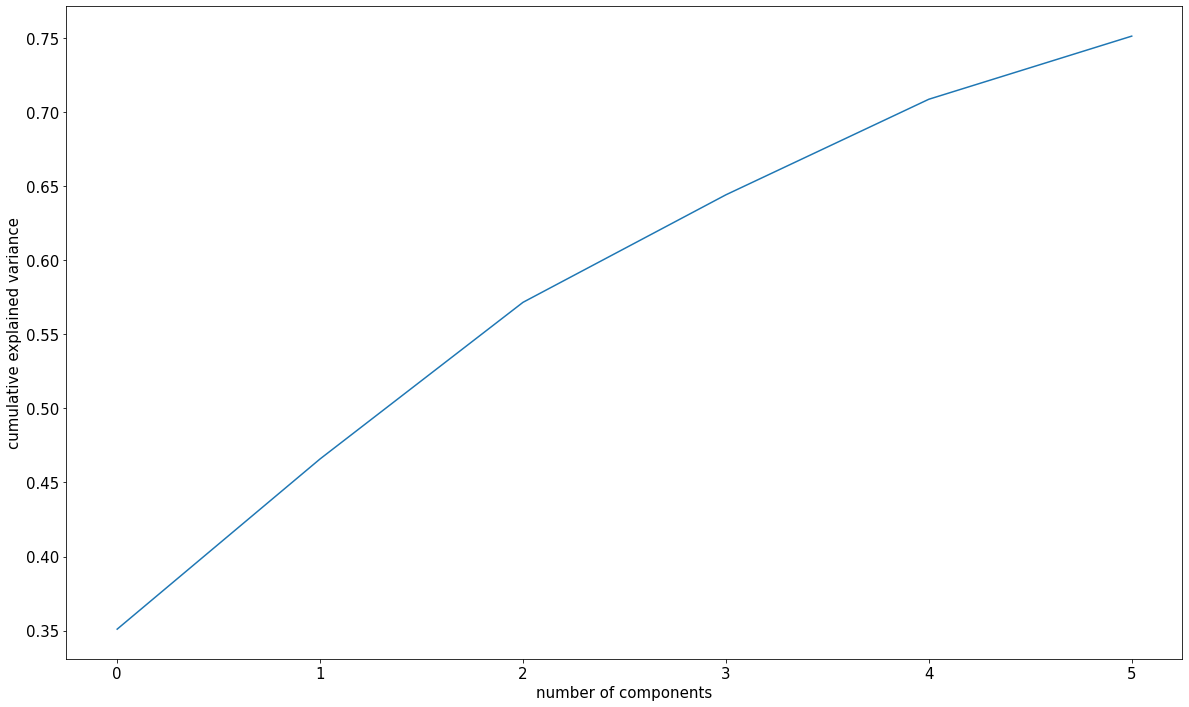

In [28]:
plt.plot(np.cumsum(portfolio_explained_variance))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

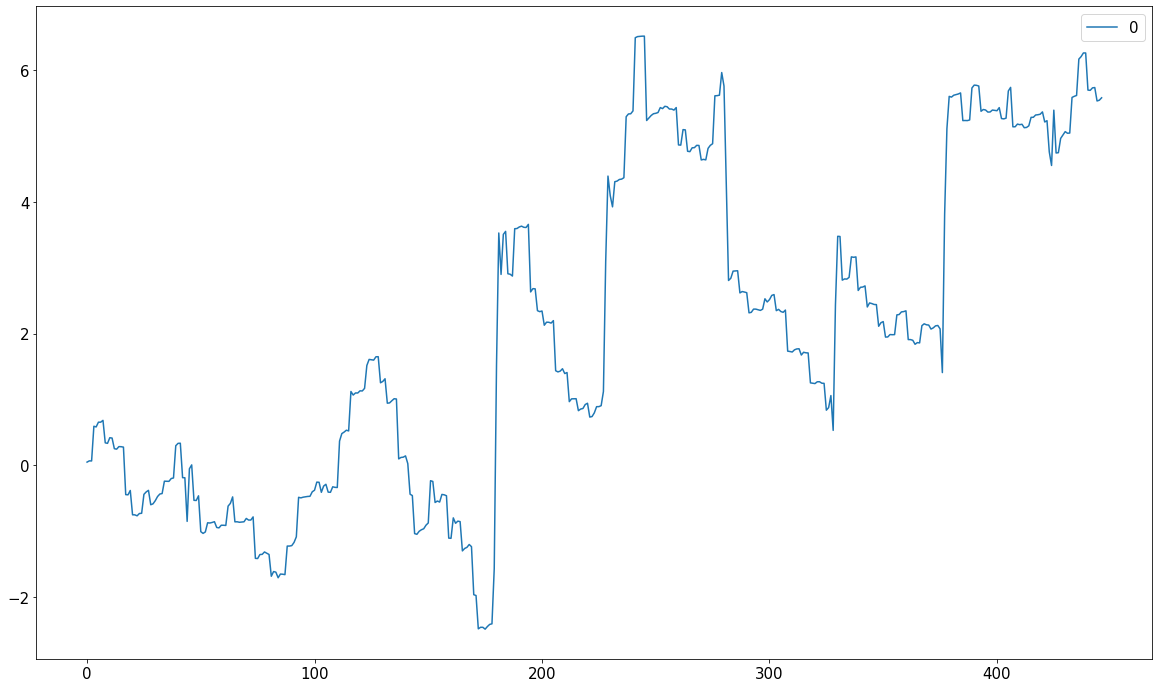

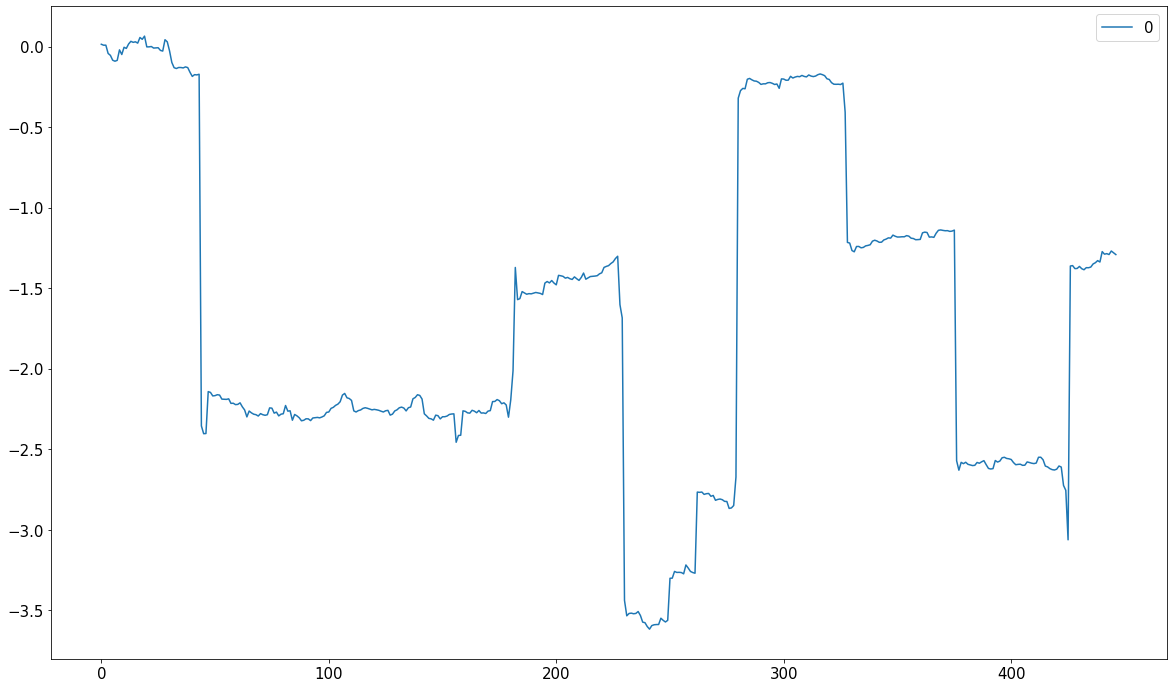

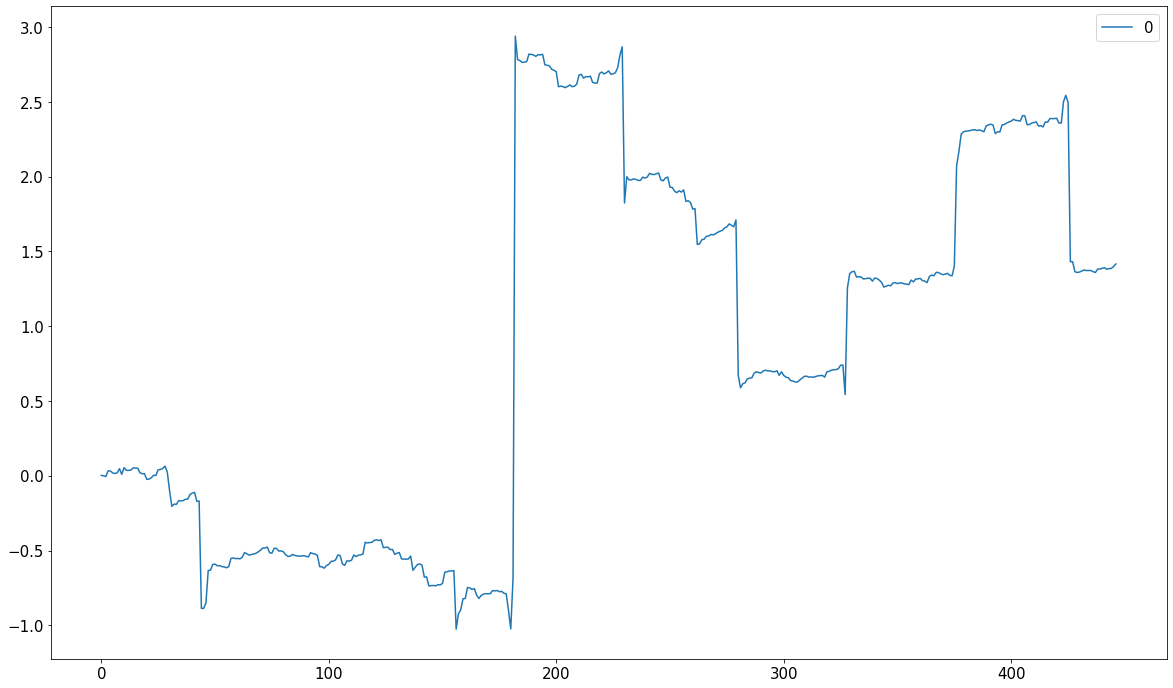

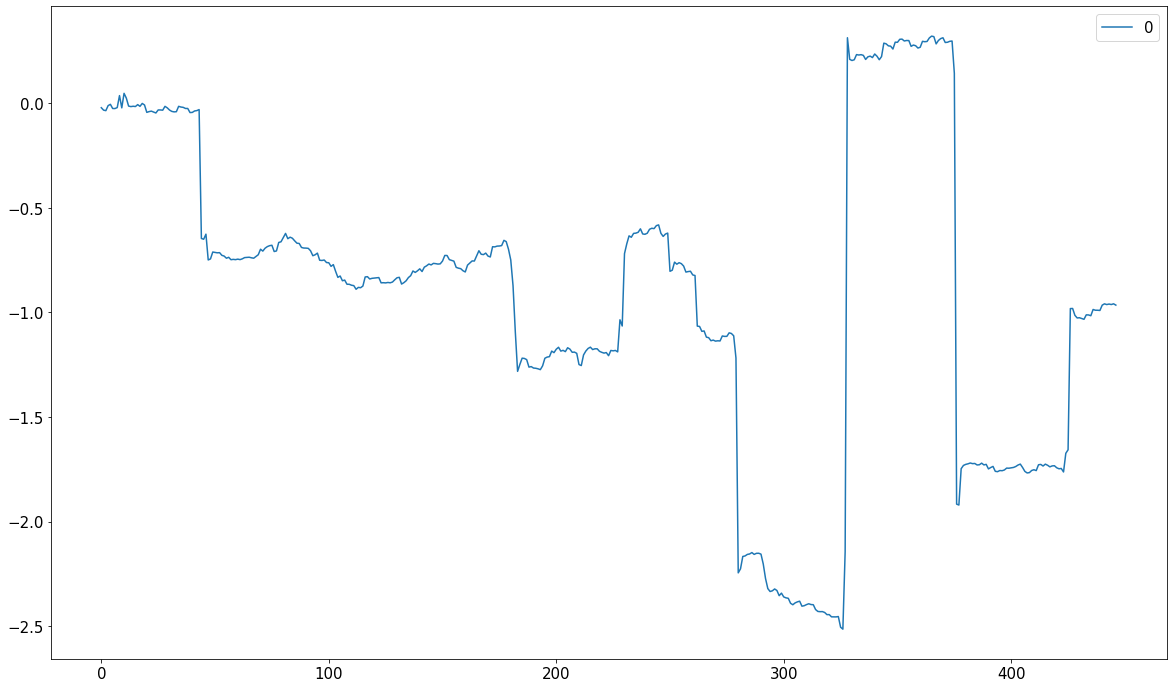

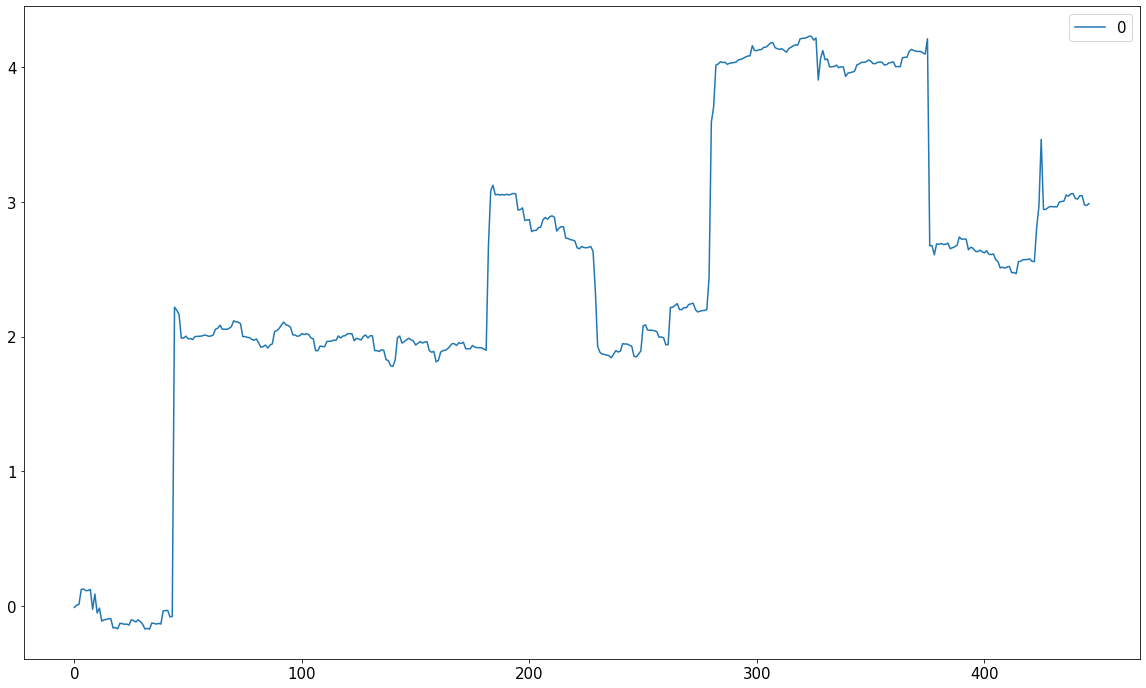

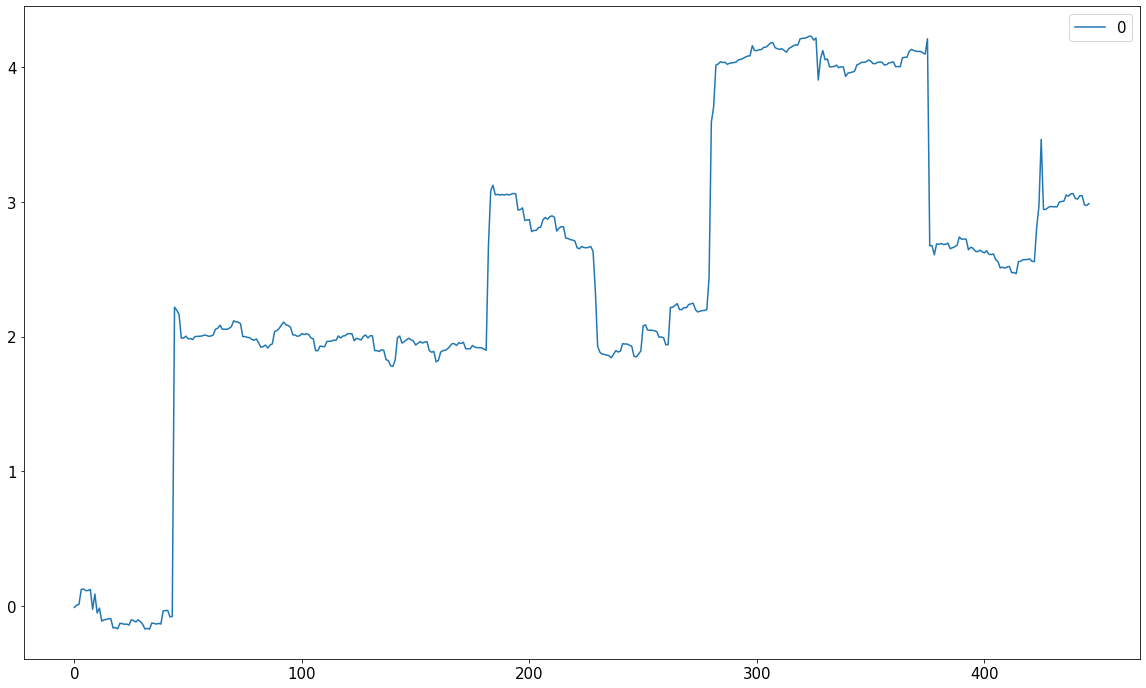

In [29]:
ev1 = pca_factors[[0]]
ev2 = pca_factors[[1]]
ev3 = pca_factors[[2]]
ev4 = pca_factors[[3]]
ev5 = pca_factors[[4]]
ev6 = pca_factors[[5]]
returns1 = pd.DataFrame(np.dot(normalized_portfolio, ev1)).cumsum()
returns2 = pd.DataFrame(np.dot(normalized_portfolio, ev2)).cumsum()
returns3 = pd.DataFrame(np.dot(normalized_portfolio, ev3)).cumsum()
returns4 = pd.DataFrame(np.dot(normalized_portfolio, ev4)).cumsum()
returns5 = pd.DataFrame(np.dot(normalized_portfolio, ev5)).cumsum()
returns6 = pd.DataFrame(np.dot(normalized_portfolio, ev6)).cumsum()
returns1.plot()
returns2.plot()
returns3.plot()
returns4.plot()
returns5.plot()
returns5.plot()

According to Pesaran and Timmermann (JoE, 2007), there is little gain for complicated procedures that try to incorporate the presence of breaks.The simple rule - split the sample at the estimated break - seems to work the best.

We split the sample portfolio data at October 1st, 2008, right after the stock market crash, and run PCA on the two sub-samples assuming full structural breaks.

In [30]:
import datetime as dt
portfolio_before2008 = normalized_portfolio[:'2008-10-01']
portfolio_after2008 = normalized_portfolio['2008-10-01':]

In [31]:
portfolio_before2008

,SMALL LoBM,ME1 BM2,ME1 BM3,ME1 BM4,ME1 BM5,ME1 BM6,ME1 BM7,ME1 BM8,ME1 BM9,SMALL HiBM,...,BIG LoBM,ME10 BM2,ME10 BM3,ME10 BM4,ME10 BM5,ME10 BM6,ME10 BM7,ME10 BM8,ME10 BM9,BIG HiBM
Time,,,,,,,,,,,,,,,,,,,,,
2004-08-01,-0.007092,-0.005479,-0.018182,0.000000,0.000000,-0.028573,0.000000,0.000000,-0.007692,-0.012870,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2004-08-01,-0.013678,-0.008587,0.010492,-0.004157,0.002989,0.003008,-0.001505,-0.001332,-0.005617,-0.004737,...,0.003601,0.000000,0.002505,0.000263,0.000648,0.000373,-0.000177,-0.002050,-0.006502,-0.008478
2004-08-01,0.006384,-0.000824,0.000954,0.000522,0.000000,0.000195,-0.000170,0.000000,-0.000241,0.001195,...,0.002112,0.000848,0.002123,0.000257,0.000000,0.000194,0.000000,-0.000572,-0.000121,-0.004222
2004-08-01,-0.132816,-0.117619,-0.049033,-0.050985,-0.045541,-0.038069,-0.053009,-0.057528,-0.039892,-0.017786,...,-0.064133,-0.025527,0.004653,-0.020536,-0.005827,-0.033157,-0.027648,-0.030529,-0.014823,-0.002936
2004-09-01,0.003056,-0.001035,-0.002259,-0.000490,0.005103,-0.007158,-0.002682,0.002662,0.002690,-0.005500,...,-0.005768,0.001697,0.001250,0.001579,0.003450,-0.003173,0.001769,-0.002495,0.002488,0.002214
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2008-05-01,-0.009390,-0.031010,0.000000,-0.007968,-0.019934,-0.006557,-0.010870,-0.004796,-0.012220,-0.027823,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2008-06-01,0.036540,0.049850,0.043221,0.042485,0.030542,0.003048,0.037706,0.031084,0.012421,0.036094,...,0.027884,0.024964,-0.016500,0.012015,-0.029214,0.031912,-0.096923,-0.007761,0.004278,0.034252
2008-06-01,-0.002673,-0.000912,-0.000699,0.001164,-0.000495,-0.000636,0.000920,0.000000,0.000675,0.001593,...,-0.002272,-0.003162,-0.000700,0.000000,-0.000245,0.000216,0.000724,0.000161,0.000000,-0.000100


In [32]:
portfolio_after2008

,SMALL LoBM,ME1 BM2,ME1 BM3,ME1 BM4,ME1 BM5,ME1 BM6,ME1 BM7,ME1 BM8,ME1 BM9,SMALL HiBM,...,BIG LoBM,ME10 BM2,ME10 BM3,ME10 BM4,ME10 BM5,ME10 BM6,ME10 BM7,ME10 BM8,ME10 BM9,BIG HiBM
Time,,,,,,,,,,,,,,,,,,,,,
2009-08-01,0.017786,0.001160,-0.000878,0.000000,-0.002753,0.000957,0.001018,0.001006,0.000618,0.042849,...,0.001113,0.001880,0.000219,0.000000,0.000143,0.000121,-0.000793,-0.000170,0.007622,-0.020518
2009-08-01,0.058463,0.098387,0.077841,0.068729,0.105855,0.105459,0.085187,0.082555,0.112940,0.131823,...,0.050071,0.061946,0.088886,0.080094,0.081434,0.040060,0.072226,0.100194,-0.037138,0.081648
2009-08-01,0.000000,0.000000,0.000000,-0.014389,0.000000,-0.017094,-0.008811,0.000000,-0.007067,-0.013346,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2009-08-01,0.033158,-0.008090,-0.009321,-0.002751,0.005865,-0.019265,0.021531,-0.009610,-0.001070,0.018620,...,0.001179,-0.001254,-0.003663,-0.001097,0.001884,0.000249,-0.002886,0.000513,0.003770,0.004521
2009-09-01,0.000000,0.000000,-0.020203,0.000000,-0.011696,-0.017392,0.000000,0.000000,-0.003552,-0.019380,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-11-01,-0.012423,0.000000,-0.028171,0.000000,0.000000,0.000000,-0.011976,-0.007547,-0.004435,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2015-12-01,0.002551,-0.000558,-0.002039,-0.001269,-0.002029,-0.001912,0.002822,-0.000721,-0.001106,-0.007356,...,0.001245,0.001666,0.000000,-0.001265,0.000787,0.001058,-0.000172,0.000147,-0.000341,-0.000408
2015-12-01,-0.005836,0.041894,0.038205,0.069110,-0.010963,0.036184,0.021299,0.029900,0.038277,0.018535,...,0.004726,-0.003207,0.007060,-0.008614,-0.014013,-0.001787,0.007357,-0.008093,0.033053,0.022970


In [33]:
# PCA before 2008
pca_model_before2008 = pca_portfolio.fit(portfolio_before2008)
pca_factors_before2008 = pd.DataFrame(pca_model_before2008.components_).T
pca_factors_before2008
ev1_before2008 = pca_factors_before2008[[0]]
ev2_before2008 = pca_factors_before2008[[1]]
ev3_before2008 = pca_factors_before2008[[2]]
ev4_before2008 = pca_factors_before2008[[3]]
ev5_before2008 = pca_factors_before2008[[4]]
ev6_before2008 = pca_factors_before2008[[5]]
return1_before2008 = pd.DataFrame(np.dot(portfolio_before2008, ev1_before2008)).cumsum()
return2_before2008 = pd.DataFrame(np.dot(portfolio_before2008, ev2_before2008)).cumsum()
return3_before2008 = pd.DataFrame(np.dot(portfolio_before2008, ev3_before2008)).cumsum()
return4_before2008 = pd.DataFrame(np.dot(portfolio_before2008, ev4_before2008)).cumsum()
return5_before2008 = pd.DataFrame(np.dot(portfolio_before2008, ev5_before2008)).cumsum()
return6_before2008 = pd.DataFrame(np.dot(portfolio_before2008, ev6_before2008)).cumsum()

# pca after 2008
pca_model_after2008 = pca_portfolio.fit(portfolio_after2008)
pca_factors_after2008 = pd.DataFrame(pca_model_after2008.components_).T
pca_factors_after2008
ev1_after2008 = pca_factors_after2008[[0]]
ev2_after2008 = pca_factors_after2008[[1]]
ev3_after2008 = pca_factors_after2008[[2]]
ev4_after2008 = pca_factors_after2008[[3]]
ev5_after2008 = pca_factors_after2008[[4]]
ev6_after2008 = pca_factors_after2008[[5]]
return1_after2008 = pd.DataFrame(np.dot(portfolio_after2008, ev1_after2008)).cumsum()
return2_after2008 = pd.DataFrame(np.dot(portfolio_after2008, ev2_after2008)).cumsum()
return3_after2008 = pd.DataFrame(np.dot(portfolio_after2008, ev3_after2008)).cumsum()
return4_after2008 = pd.DataFrame(np.dot(portfolio_after2008, ev4_after2008)).cumsum()
return5_after2008 = pd.DataFrame(np.dot(portfolio_after2008, ev5_after2008)).cumsum()
return6_after2008 = pd.DataFrame(np.dot(portfolio_after2008, ev6_after2008)).cumsum()

In [34]:
normalized_portfolio

,SMALL LoBM,ME1 BM2,ME1 BM3,ME1 BM4,ME1 BM5,ME1 BM6,ME1 BM7,ME1 BM8,ME1 BM9,SMALL HiBM,...,BIG LoBM,ME10 BM2,ME10 BM3,ME10 BM4,ME10 BM5,ME10 BM6,ME10 BM7,ME10 BM8,ME10 BM9,BIG HiBM
Time,,,,,,,,,,,,,,,,,,,,,
2004-08-01,-0.007092,-0.005479,-0.018182,0.000000,0.000000,-0.028573,0.000000,0.000000,-0.007692,-0.012870,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2004-08-01,-0.013678,-0.008587,0.010492,-0.004157,0.002989,0.003008,-0.001505,-0.001332,-0.005617,-0.004737,...,0.003601,0.000000,0.002505,0.000263,0.000648,0.000373,-0.000177,-0.002050,-0.006502,-0.008478
2004-08-01,0.006384,-0.000824,0.000954,0.000522,0.000000,0.000195,-0.000170,0.000000,-0.000241,0.001195,...,0.002112,0.000848,0.002123,0.000257,0.000000,0.000194,0.000000,-0.000572,-0.000121,-0.004222
2004-08-01,-0.132816,-0.117619,-0.049033,-0.050985,-0.045541,-0.038069,-0.053009,-0.057528,-0.039892,-0.017786,...,-0.064133,-0.025527,0.004653,-0.020536,-0.005827,-0.033157,-0.027648,-0.030529,-0.014823,-0.002936
2004-09-01,0.003056,-0.001035,-0.002259,-0.000490,0.005103,-0.007158,-0.002682,0.002662,0.002690,-0.005500,...,-0.005768,0.001697,0.001250,0.001579,0.003450,-0.003173,0.001769,-0.002495,0.002488,0.002214
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-11-01,-0.012423,0.000000,-0.028171,0.000000,0.000000,0.000000,-0.011976,-0.007547,-0.004435,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2015-12-01,0.002551,-0.000558,-0.002039,-0.001269,-0.002029,-0.001912,0.002822,-0.000721,-0.001106,-0.007356,...,0.001245,0.001666,0.000000,-0.001265,0.000787,0.001058,-0.000172,0.000147,-0.000341,-0.000408
2015-12-01,-0.005836,0.041894,0.038205,0.069110,-0.010963,0.036184,0.021299,0.029900,0.038277,0.018535,...,0.004726,-0.003207,0.007060,-0.008614,-0.014013,-0.001787,0.007357,-0.008093,0.033053,0.022970


# Conclusion

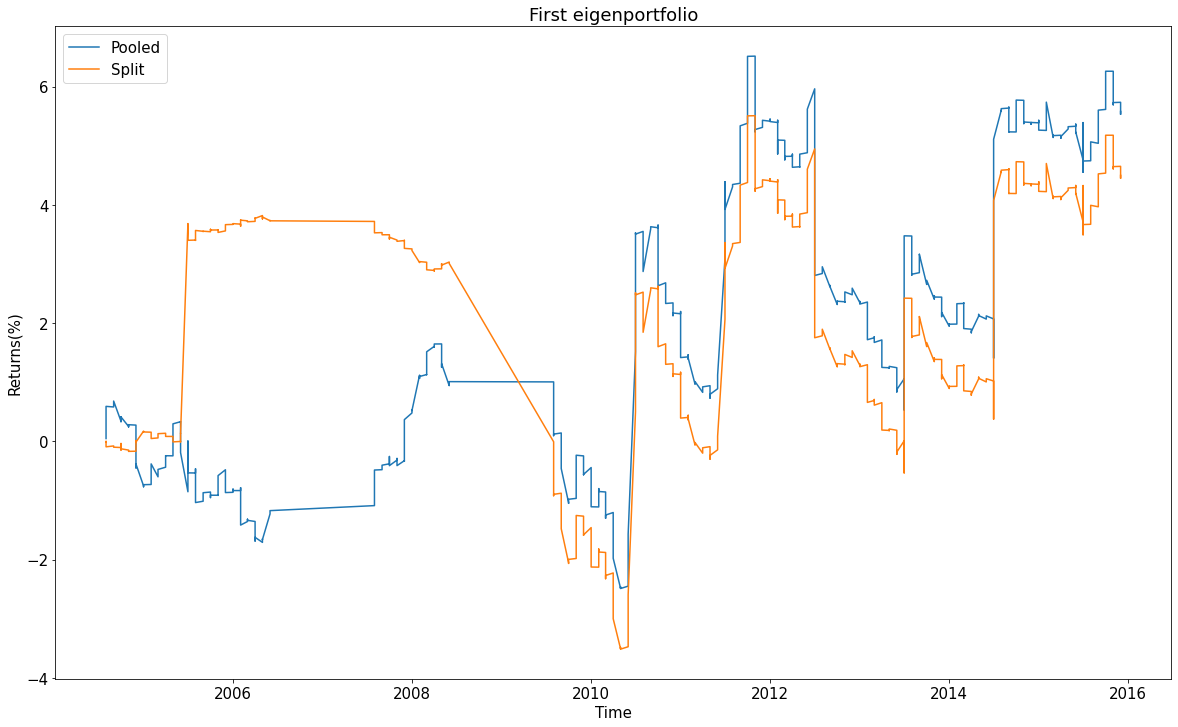

In [44]:
date_index = pd.to_datetime(normalized_portfolio.index)
plt.plot(returns1.set_index(date_index))
split_returns1 = pd.concat([return1_before2008, return1_after2008],
                           ignore_index=True, sort=False).set_index(date_index) # returns of first eigenportfolio with break
plt.plot(split_returns1)
plt.title('First eigenportfolio')
plt.legend(['Pooled','Split'], loc = 'upper left')
plt.xlabel('Time')
plt.ylabel('Returns(%)');

**Observation**: The returns incorporating the split give a much higher estimate of the impact of the 2008 crash (because it's much higher before 2008 and a little bit lower after 2008). This is a better description since PCA on the entire set will "smooth out" the impact.

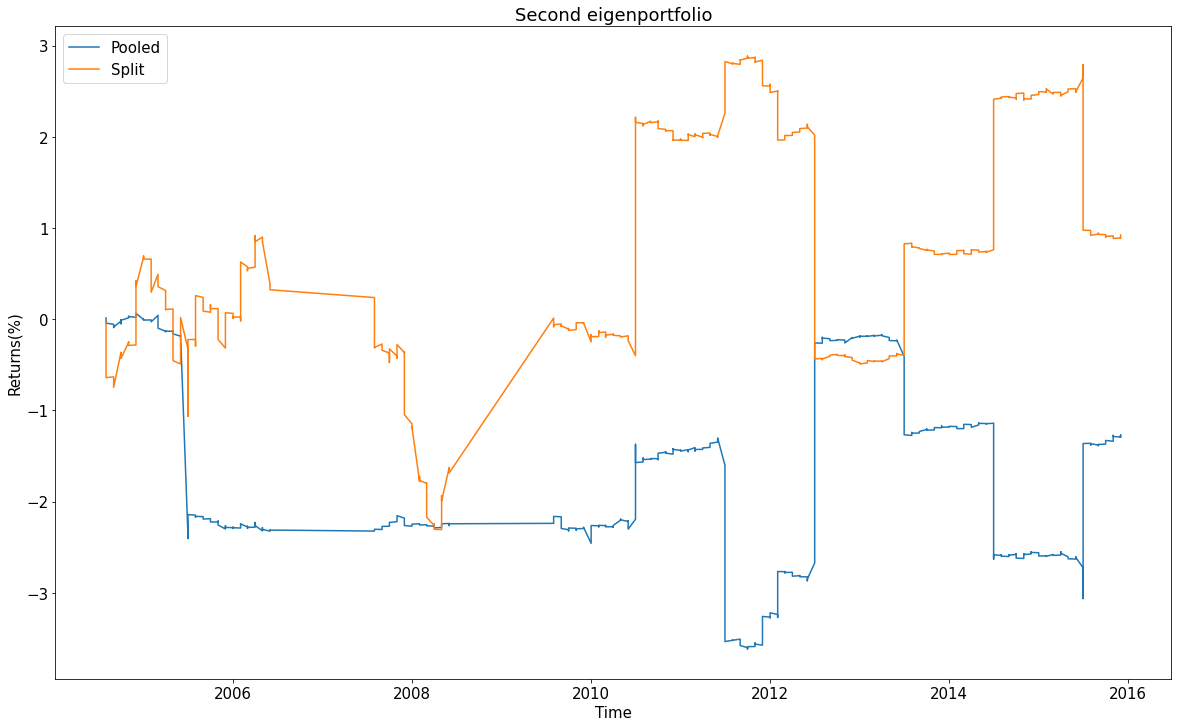

In [45]:
plt.plot(returns2.set_index(date_index))
split_returns2 = pd.concat([return2_before2008, return2_after2008],
                           ignore_index=True, sort=False).set_index(date_index) # returns of second eigenportfolio with break
plt.plot(split_returns2)
plt.legend(['Pooled','Split'], loc = 'upper left')
plt.title('Second eigenportfolio')
plt.xlabel('Time')
plt.ylabel('Returns(%)');

**Observation**: After 2008, the split returns look like a mirror reflection of the actual returns, indicating an eigenvalue after 2008 has an opposite sign. We suspect this may be due to overfitting.

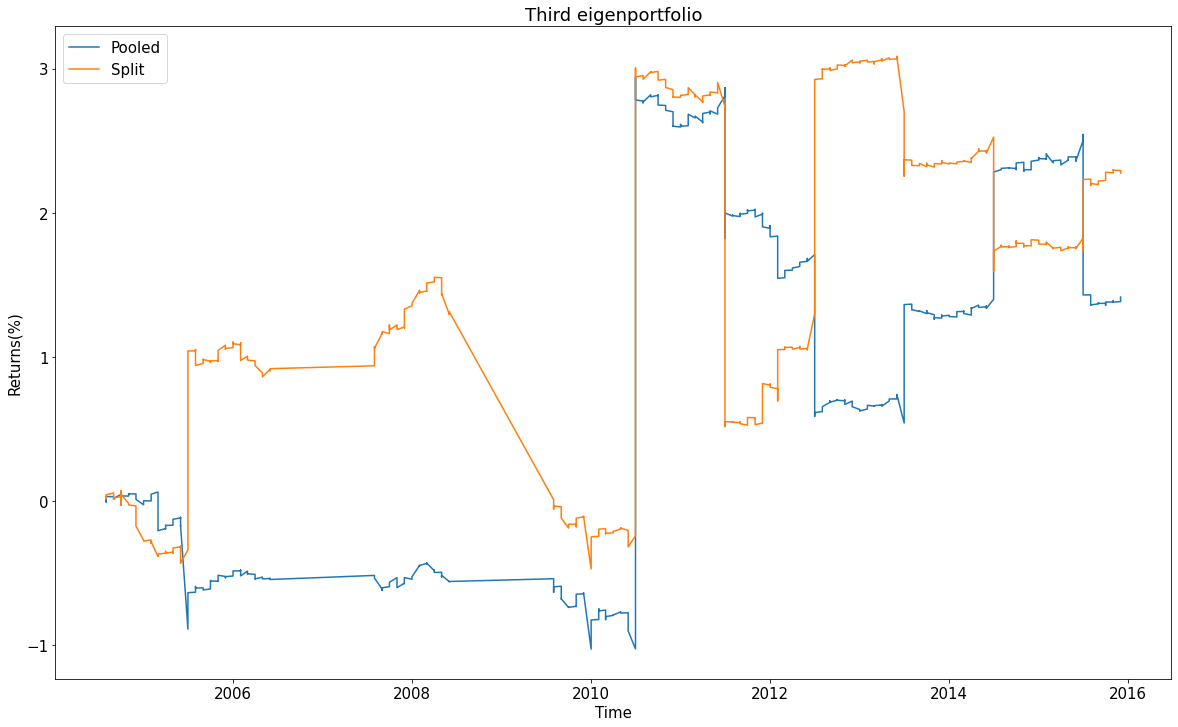

In [46]:
plt.plot(returns3.set_index(date_index))
split_returns3 = pd.concat([return3_before2008, return3_after2008],
                           ignore_index=True, sort=False).set_index(date_index) # returns of third eigenportfolio with break
plt.plot(split_returns3)
plt.legend(['Pooled','Split'], loc = 'upper left')
plt.title('Third eigenportfolio')
plt.xlabel('Time')
plt.ylabel('Returns(%)');

**Observation**: The split returns after 2008 again look like a mirror reflection of the combined returns, but the mirroring is not as "exact" as in the previous portfolio. We suspect that this may either be overfitting, or there may be an indicator that varies inversely with market returns.

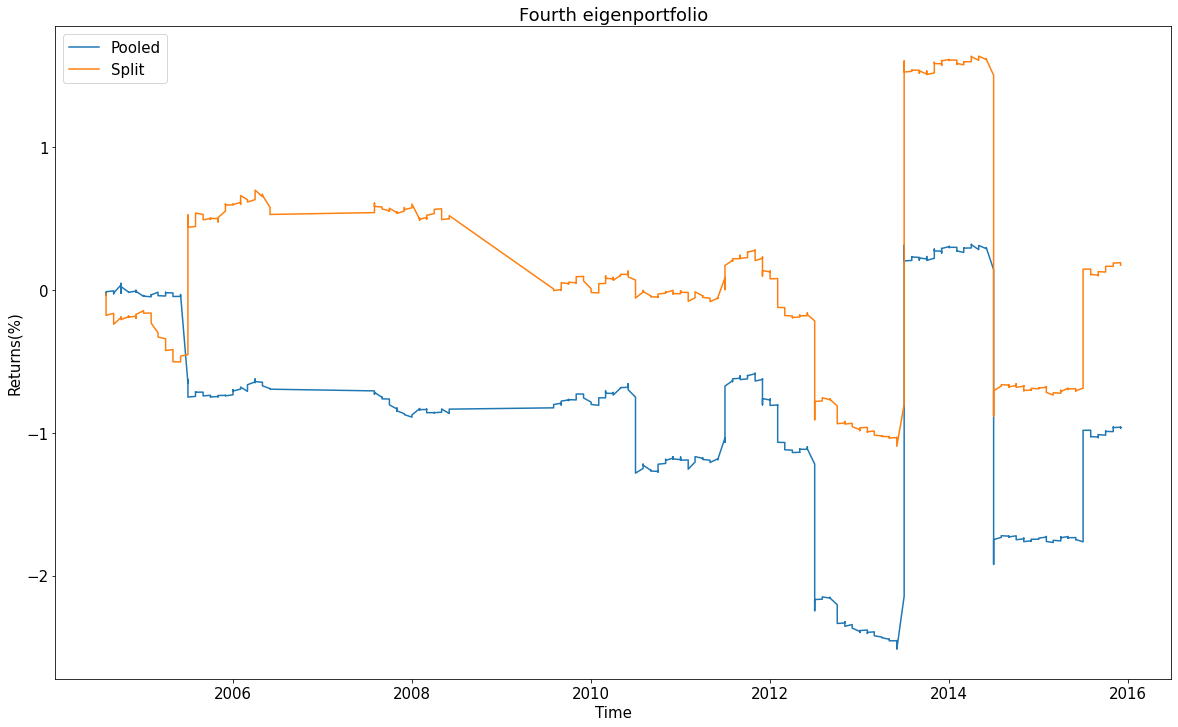

In [47]:
plt.plot(returns4.set_index(date_index))
split_returns4 = pd.concat([return4_before2008, return4_after2008],
                           ignore_index=True, sort=False).set_index(date_index) # returns of fourth eigenportfolio with break
plt.plot(split_returns4)
plt.legend(['Pooled','Split'], loc = 'upper left')
plt.title('Fourth eigenportfolio')
plt.xlabel('Time')
plt.ylabel('Returns(%)');

**Observation**: The split portfolio is very similar before and after 2008 (except for a mild downward trend throughout 2009), except for in 2005. Googling reveals that the stock market did relatively well in 2005, which the split PCA picked up but not the combined PCA.

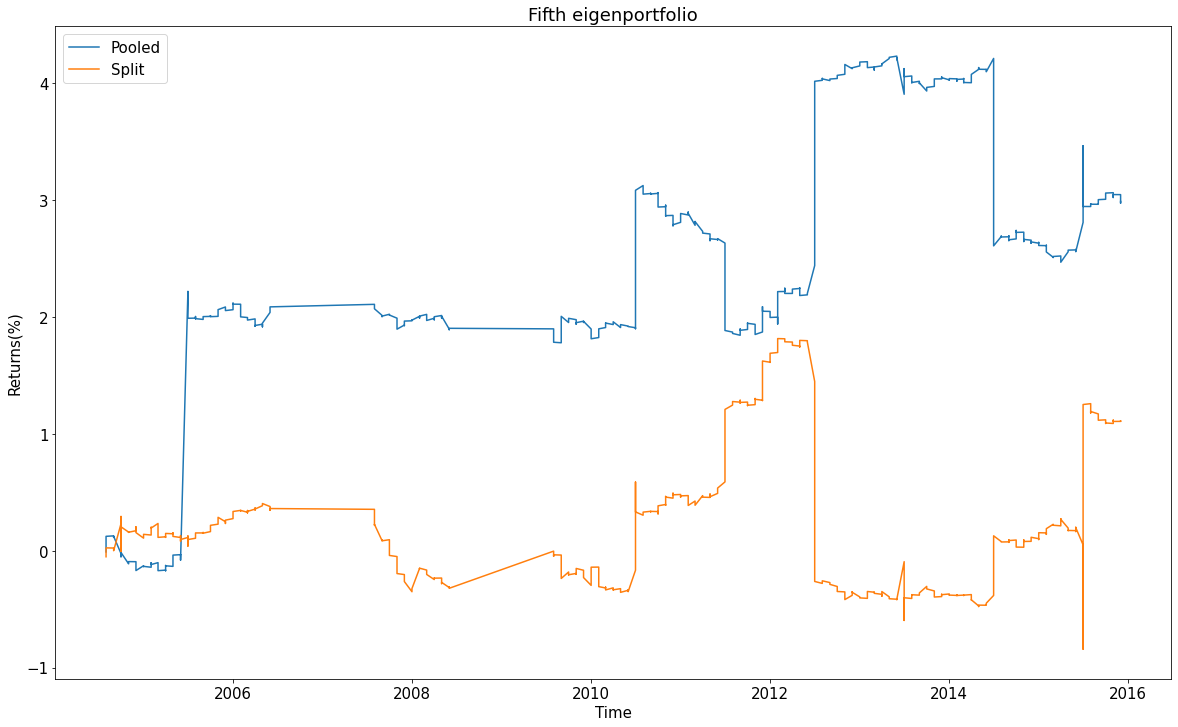

In [48]:
plt.plot(returns5.set_index(date_index))
split_returns5 = pd.concat([return5_before2008, return5_after2008],
                           ignore_index=True, sort=False).set_index(date_index) # returns of first eigenportfolio with break
plt.plot(split_returns5)
plt.legend(['Pooled','Split'], loc = 'upper left')
plt.title('Fifth eigenportfolio')
plt.xlabel('Time')
plt.ylabel('Returns(%)');

**Observation**: This is the opposite of the previous graph, where the combined PCA showed a large increase in 2005 but not the split PCA. Since this is the 5th eigenvalue, and the graphs are "mirror reflections" after 2008, we suspect that this eigenvalue does not explain much in the dataset, or that it is another negative eigenvalue from overfitting.

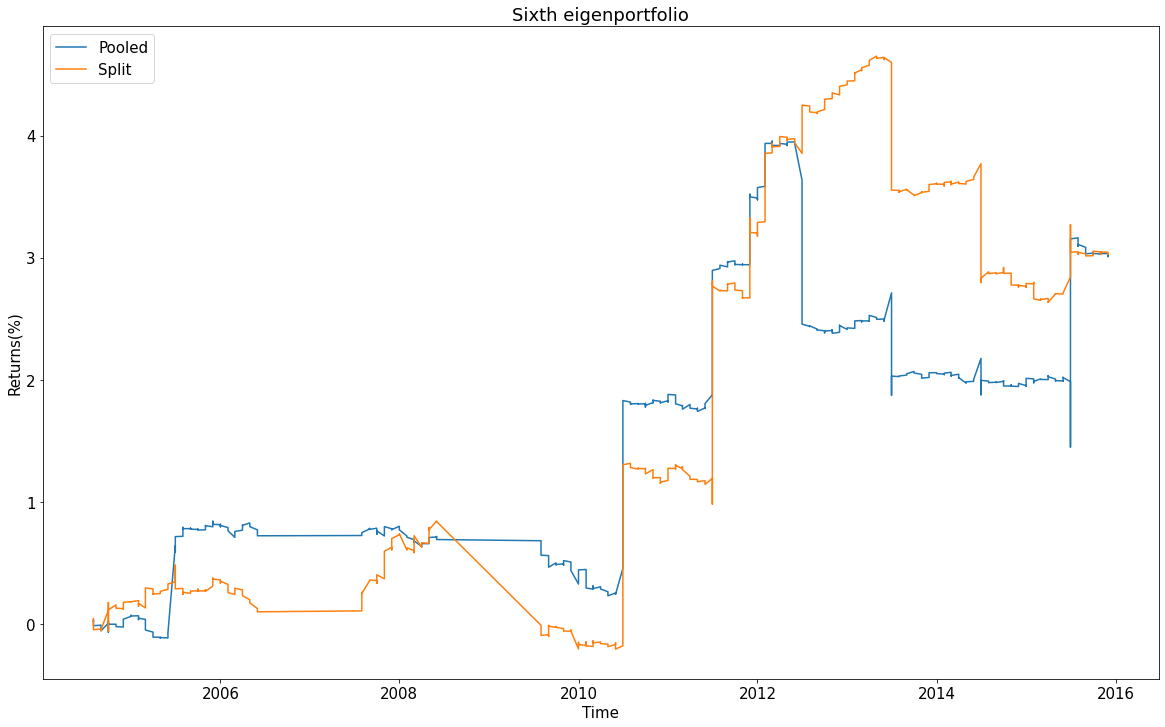

In [49]:
plt.plot(returns6.set_index(date_index))
split_returns6 = pd.concat([return6_before2008, return6_after2008],
                           ignore_index=True, sort=False).set_index(date_index) # returns of first eigenportfolio with break
plt.plot(split_returns6)
plt.legend(['Pooled','Split'], loc = 'upper left')
plt.title('Sixth eigenportfolio')
plt.xlabel('Time')
plt.ylabel('Returns(%)');

**Observation**: There is not much difference between the 2 graphs besides the split PCA showing a mild downward trend after 2008, and the market returns are a bit lower for a couple years afterward. This is consistent with observations from the 1st portfolio, but the trend here is weaker. We suspect it's because this one of the less significant eigenvalues, so it does not explain too much of the trend shown.

# Reference

Mikkelsen, J. G. (2016). Time-varying loadings in factor models: Theory and applications. Aarhus : Aarhus BSS, Aarhus University, Department of Economics and Business Economics.

Stock, J., & Watson, M. (2002). Forecasting Using Principal Components from a Large Number of Predictors. Journal of the American Statistical Association, 97(460), 1167-1179.

Bai, J., Ng, S. (2002). Determining the number of factors in approximate factor models. Econometrica 70 (1), 191–221.

Fama, Eugene F. and French, Kenneth R. (2014). A Five-Factor Asset Pricing Model.

Jörg Breitung, Sandra Eickmeier. (2011). Testing for structural breaks in dynamic factor models. Journal of Econometrics, Volume 163, Issue 1.